    Try to model polyphonic music.
    Since music is (obviously) temporally coherent, we need a model that can represent complex time dependencies in the observed data.
    One particular realization of this idea is a markov model, in which we have a chain of latent variables, with each latent variable in the chain conditioned on the previous latent variable. 
    
    z: latent variable (hidden state)
    z -> x : 88-dim vector
    z0 -> z1: produce mean/variance --> gaussian distribution (decide z1)

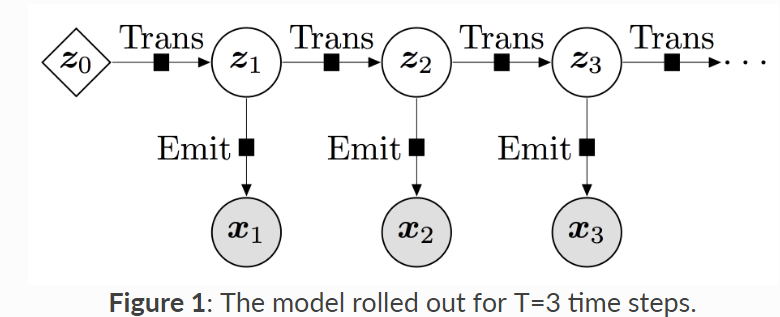

In [1]:
from IPython.display import Image
Image("fig1.png", width=500, height=500)

    We will assume that the observation likelihoods, i.e. the probability distributions p(xt|zt) that control the observations, are given by the bernoulli distribution. 
    Note that the black squares appear in two different places: in between pairs of latents and in between latents and observations. 
    
    Notes: we can choose dimensions depending on complexity of problems

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn

import pyro
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood p(x_t | z_t)
    """
    def __init__(self, input_dim, z_dim, emission_dim):
        super(Emitter, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        #!! sigmoid output (range: [0, 1]) is bernoulli's parameters

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution p(x_t|z_t)
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = self.sigmoid(self.lin_hidden_to_input(h2))
        
        
        return ps

    Need to output loc and scale for gaussian distrbution
    z(t-1) --> z(t)，output paras for gaussian distrbution

In [4]:
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    See section 5 in the reference for comparison.
    """
    def __init__(self, z_dim, transition_dim):
        super(GatedTransition, self).__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        """
        Given the latent z_{t-1} corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes
        # a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        
        #! add nonlinearily to linearity
        #! z_t_1 us previous output, while proposed_mean is guessed
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed
        # mean from above as input. the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

In [6]:
def model(self, mini_batch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lengths, annealing_factor=1.0):

    # this is the number of time steps we need to process in the mini-batch
    T_max = mini_batch.size(1)

    # register all PyTorch (sub)modules with pyro
    # this needs to happen in both the model and guide
    pyro.module("dmm", self)

    # set z_prev = z_0 to setup the recursive conditioning in p(z_t | z_{t-1})
    z_prev = self.z_0.expand(mini_batch.size(0), self.z_0.size(0))

    # we enclose all the sample statements in the model in a iarange.
    # this marks that each datapoint is conditionally independent of the others
    with pyro.iarange("z_minibatch", len(mini_batch)):
        # sample the latents z and observed x's one time step at a time
        for t in range(1, T_max + 1):
            # the next chunk of code samples z_t ~ p(z_t | z_{t-1})
            # note that (both here and elsewhere) we use poutine.scale to take care
            # of KL annealing. we use the mask() method to deal with raggedness
            # in the observed data (i.e. different sequences in the mini-batch
            # have different lengths)

            # first compute the parameters of the diagonal gaussian
            # distribution p(z_t | z_{t-1})
            z_loc, z_scale = self.trans(z_prev)

            # then sample z_t according to dist.Normal(z_loc, z_scale).
            # note that we use the reshape method so that the univariate
            # Normal distribution is treated as a multivariate Normal
            # distribution with a diagonal covariance.
            with poutine.scale(None, annealing_factor):
                z_t = pyro.sample("z_%d" % t,
                                  dist.Normal(z_loc, z_scale)
                                      .mask(mini_batch_mask[:, t - 1:t])
                                      .independent(1))

            # compute the probabilities that parameterize the bernoulli likelihood
            emission_probs_t = self.emitter(z_t)
            # the next statement instructs pyro to observe x_t according to the
            # bernoulli distribution p(x_t|z_t)
            pyro.sample("obs_x_%d" % t,
                        dist.Bernoulli(emission_probs_t)
                            .mask(mini_batch_mask[:, t - 1:t])
                            .independent(1),
                        obs=mini_batch[:, t - 1, :])
            # the latent sampled at this time step will be conditioned upon
            # in the next time step so keep track of it
            z_prev = z_t

### Inference

    This module has the same general structure as Emitter and GatedTransition in the model. The only thing of note is that because the Combiner needs to consume two inputs at each time step, it transforms the inputs into a single combined hidden state h_combined before it computes the outputs.

In [7]:
class Combiner(nn.Module):
    """
    Parameterizes q(z_t | z_{t-1}, x_{t:T}), which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on x_{t:T} is
    through the hidden state of the RNN (see the pytorch module `rnn` below)
    """
    def __init__(self, z_dim, rnn_dim):
        super(Combiner, self).__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN h(x_{t:T}) we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution q(z_t | z_{t-1}, x_{t:T})
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale

In [8]:
def guide(self, mini_batch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lengths, annealing_factor=1.0):

    # this is the number of time steps we need to process in the mini-batch
    T_max = mini_batch.size(1)
    # register all PyTorch (sub)modules with pyro
    pyro.module("dmm", self)

    # if on gpu we need the fully broadcast view of the rnn initial state
    # to be in contiguous gpu memory
    h_0_contig = self.h_0.expand(1, mini_batch.size(0),
                                 self.rnn.hidden_size).contiguous()
    # push the observed x's through the rnn;
    # rnn_output contains the hidden state at each time step
    rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
    # reverse the time-ordering in the hidden state and un-pack it
    rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)
    # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
    z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))

    # we enclose all the sample statements in the guide in a iarange.
    # this marks that each datapoint is conditionally independent of the others.
    with pyro.iarange("z_minibatch", len(mini_batch)):
        # sample the latents z one time step at a time
        for t in range(1, T_max + 1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
            z_dist = dist.Normal(z_loc, z_scale)

            # sample z_t from the distribution z_dist
            with pyro.poutine.scale(None, annealing_factor):
                z_t = pyro.sample("z_%d" % t,
                                  z_dist.mask(mini_batch_mask[:, t - 1:t])
                                        .independent(1))
            # the latent sampled at this time step will be conditioned
            # upon in the next time step so keep track of it
            z_prev = z_t


In [9]:
class DMM(nn.Module):
    """
    This PyTorch Module encapsulates the model as well as the
    variational distribution (the guide) for the Deep Markov Model
    """
    def __init__(self, input_dim=88, z_dim=100, emission_dim=100,
                 transition_dim=200, rnn_dim=600, rnn_dropout_rate=0.0,
                 num_iafs=0, iaf_dim=50, use_cuda=False):
        super(DMM, self).__init__()
        # instantiate pytorch modules used in the model and guide below
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim,
                          nonlinearity='relu', batch_first=True,
                          bidirectional=False, num_layers=1, dropout=rnn_dropout_rate)

        # define a (trainable) parameters z_0 and z_q_0 that help define
        # the probability distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all pytorch (sub)modules
        if use_cuda:
            self.cuda()

    # the model p(x_{1:T} | z_{1:T}) p(z_{1:T})
    def model(...):

        # ... as above ...

    # the guide q(z_{1:T} | x_{1:T}) (i.e. the variational distribution)
    def guide(...):

        # ... as above ...

SyntaxError: invalid syntax (<ipython-input-9-2f40c86cf631>, line 32)

In [10]:
# instantiate the dmm
dmm = DMM(input_dim, z_dim, emission_dim, transition_dim, rnn_dim,
          args.rnn_dropout_rate, args.num_iafs, args.iaf_dim, args.cuda)

# setup optimizer
adam_params = {"lr": args.learning_rate, "betas": (args.beta1, args.beta2),
               "clip_norm": args.clip_norm, "lrd": args.lr_decay,
               "weight_decay": args.weight_decay}
optimizer = ClippedAdam(adam_params)

# setup inference algorithm
svi = SVI(dmm.model, dmm.guide, optimizer, Trace_ELBO())

svi.step(mini_batch, ...)

NameError: name 'DMM' is not defined

In [11]:
jsb_file_loc = "./data/jsb_processed.pkl"
data = pickle.load(open(jsb_file_loc, "rb"))
training_seq_lengths = data['train']['sequence_lengths']
training_data_sequences = data['train']['sequences']
test_seq_lengths = data['test']['sequence_lengths']
test_data_sequences = data['test']['sequences']
val_seq_lengths = data['valid']['sequence_lengths']
val_data_sequences = data['valid']['sequences']
N_train_data = len(training_seq_lengths)
N_train_time_slices = np.sum(training_seq_lengths)
N_mini_batches = int(N_train_data / args.mini_batch_size +
                     int(N_train_data % args.mini_batch_size > 0))

NameError: name 'pickle' is not defined

In [12]:
def process_minibatch(epoch, which_mini_batch, shuffled_indices):
    if args.annealing_epochs > 0 and epoch < args.annealing_epochs:
        # compute the KL annealing factor appropriate
        # for the current mini-batch in the current epoch
        min_af = args.minimum_annealing_factor
        annealing_factor = min_af + (1.0 - min_af) * \
            (float(which_mini_batch + epoch * N_mini_batches + 1) /
             float(args.annealing_epochs * N_mini_batches))
    else:
        # by default the KL annealing factor is unity
        annealing_factor = 1.0

    # compute which sequences in the training set we should grab
    mini_batch_start = (which_mini_batch * args.mini_batch_size)
    mini_batch_end = np.min([(which_mini_batch + 1) * args.mini_batch_size,
                             N_train_data])
    mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]
    # grab the fully prepped mini-batch using the helper function in the data loader
    mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
        = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                              training_seq_lengths, cuda=args.cuda)
    # do an actual gradient step
    loss = svi.step(mini_batch, mini_batch_reversed, mini_batch_mask,
                     mini_batch_seq_lengths, annealing_factor)
    # keep track of the training loss
    return loss

In [ ]:
times = [time.time()]
for epoch in range(args.num_epochs):
    # accumulator for our estimate of the negative log likelihood
    # (or rather -elbo) for this epoch
    epoch_nll = 0.0
    # prepare mini-batch subsampling indices for this epoch
    shuffled_indices = np.arange(N_train_data)
    np.random.shuffle(shuffled_indices)

    # process each mini-batch; this is where we take gradient steps
    for which_mini_batch in range(N_mini_batches):
        epoch_nll += process_minibatch(epoch, which_mini_batch, shuffled_indices)

    # report training diagnostics
    times.append(time.time())
    epoch_time = times[-1] - times[-2]
    log("[training epoch %04d]  %.4f \t\t\t\t(dt = %.3f sec)" %
        (epoch, epoch_nll / N_train_time_slices, epoch_time))

### Evaluation